In [10]:
import numpy as np
from pydpmd.utils import split_systems, join_systems
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
def obj_func(b, x, y, m):
    return np.sum((m * x + b - y) ** 2)

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

In [22]:
root = '/home/mmccraw/dev/data/10-01-25/new-moment-of-inertia/'
dataset = []
file_index = 0
while os.path.exists(file_path := os.path.join(root, f'dynamics_{file_index}')):
    file_index += 1
    try:
        data = load(file_path, location=['final', 'init'], load_trajectory=True, load_full=False)
    except:
        continue
    data.calculate_mu_eff()
    msd_path = os.path.join(file_path, 'msd.npz')
    gmsd, t = compute_rotational_msd(data, msd_path)
    msd = gmsd[:, :, 0]
    amsd = gmsd[:, :, 1]

    pressure = 0.5 * np.mean([data.trajectory[i].stress_tensor_total_x[:, 0] + data.trajectory[i].stress_tensor_total_y[:, 1] for i in range(data.trajectory.num_frames())], axis=0)
    ke_trans = np.add.reduceat(np.mean(0.5 * np.sum(np.array([data.trajectory[i].vel for i in range(data.trajectory.num_frames())]) ** 2, axis=-1) * data.mass[None, :], axis=0), data.system_offset[:-1])
    ke_trans_fluc = np.add.reduceat(np.std(0.5 * np.sum(np.array([data.trajectory[i].vel for i in range(data.trajectory.num_frames())]) ** 2, axis=-1) * data.mass[None, :], axis=0), data.system_offset[:-1])
    ke_rot = np.add.reduceat(np.mean(np.array([data.trajectory[i].angular_vel ** 2 for i in range(data.trajectory.num_frames())]) * data.moment_inertia, axis=0), data.system_offset[:-1])
    ke_rot_fluc = np.add.reduceat(np.std(np.array([data.trajectory[i].angular_vel ** 2 for i in range(data.trajectory.num_frames())]) * data.moment_inertia, axis=0), data.system_offset[:-1])
    ke_total = np.mean([data.trajectory[i].ke_total for i in range(data.trajectory.num_frames())], axis=0)
    pe_total = np.mean([data.trajectory[i].pe_total for i in range(data.trajectory.num_frames())], axis=0)

    keys = np.column_stack((data.mu_eff[data.system_offset[:-1]], data.n_vertices_per_particle[data.system_offset[:-1]]))
    cut = keys.shape[0] // 2
    for i, key in enumerate(keys):
        m = msd[:, i]
        am = amsd[:, i]
        short_time_mask = t < t.min() * 10
        long_time_mask = t > t.max() / 10
        D_T_short = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[short_time_mask]), np.log10(m[short_time_mask]), 2)).x
        D_T_long = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[long_time_mask]), np.log10(m[long_time_mask]), 1)).x
        D_R_short = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[short_time_mask]), np.log10(am[short_time_mask]), 2)).x
        D_R_long = 10 ** minimize(obj_func, x0=1, args=(np.log10(t[long_time_mask]), np.log10(am[long_time_mask]), 1)).x
        dataset.append(
            {
                'mu_eff': key[0],
                'n_vertices': key[1],
                'phi': data.packing_fraction[i],
                'ke_rot': ke_rot[i],
                'ke_rot_fluc': ke_rot_fluc[i],
                'ke_trans': ke_trans[i],
                'ke_trans_fluc': ke_trans_fluc[i],
                'ke_total': ke_total[i],
                'pe_total': pe_total[i],
                'pressure': pressure[i],
                'is_old': i < cut,
                'msd': msd[:, i],
                'amsd': amsd[:, i],
                't': t,
                'D_T_short': D_T_short,
                'D_T_long': D_T_long,
                'D_R_short': D_R_short,
                'D_R_long': D_R_long,
            }
        )

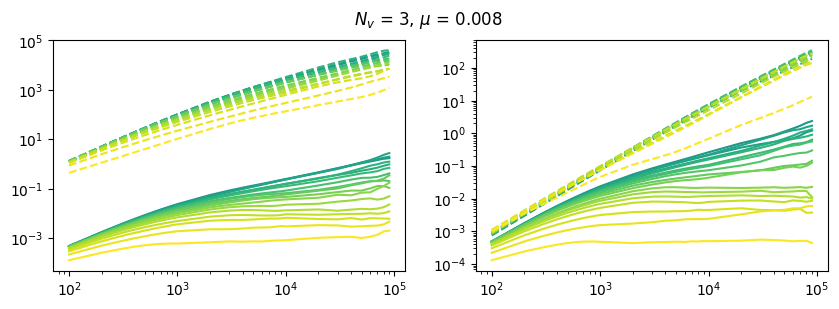

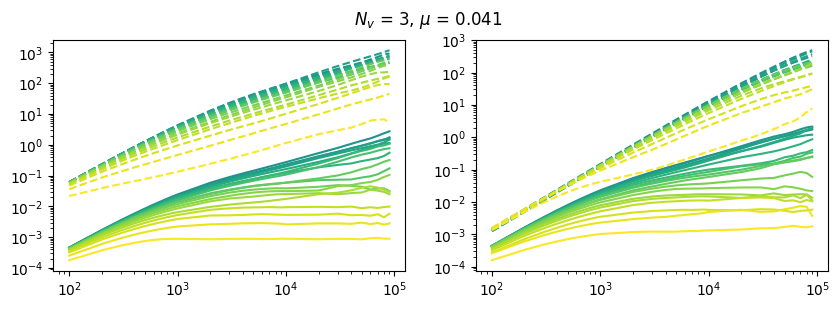

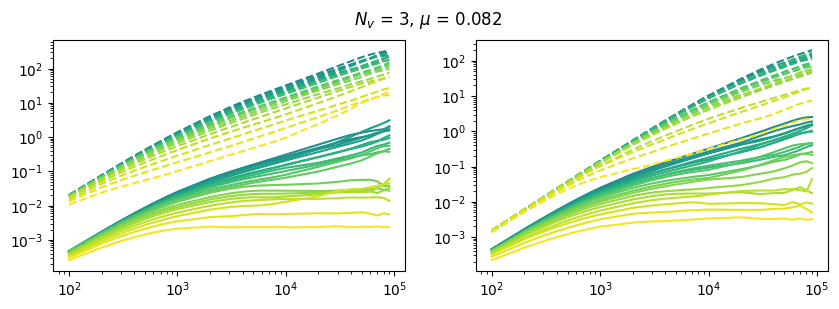

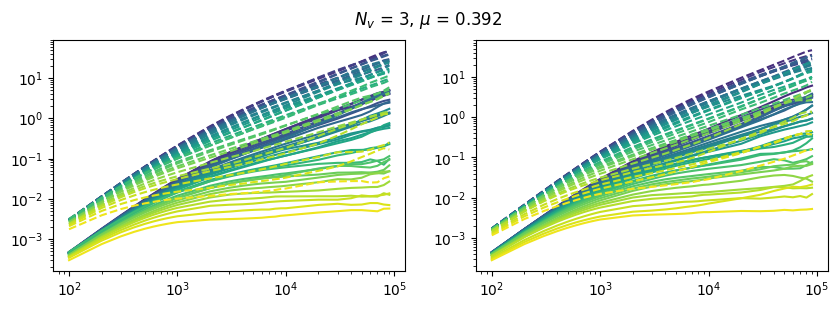

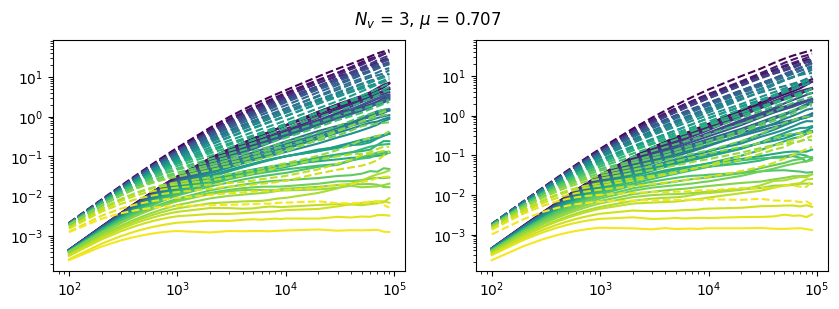

In [9]:
phis = np.unique(np.array([d['phi'] for d in dataset]))
phi_norm = plt.Normalize(min(phis), max(phis))
cmap = plt.cm.viridis

nv = 4
for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for d in dataset:
        if d['n_vertices'] != nv:
            continue
        if d['mu_eff'] != mu:
            continue
        if d['is_old']:
            a = ax[0]
        else:
            a = ax[1]
        a.plot(d['t'], d['msd'], c=cmap(phi_norm(d['phi'])))
        a.plot(d['t'], d['amsd'], c=cmap(phi_norm(d['phi'])), linestyle='--')
        # fit_mask = d['t'] < d['t'].min() * 10
        # n, log_D = np.polyfit(np.log10(d['t'][fit_mask]), np.log10(d['amsd'][fit_mask]), 1)
        # D = 10 ** log_D
        # a.plot(d['t'], D * d['t'] ** n, c=cmap(phi_norm(d['phi'])), linestyle=':')
        # print(n)
    for a in ax:
        a.set_xscale('log')
        a.set_yscale('log')
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    plt.show()

/tmp/ipykernel_1925270/3588775571.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(d['phi'], d['ke_rot_fluc'], c=cmap(phi_norm(d['phi'])), marker='o' if d['is_old'] else 'x')


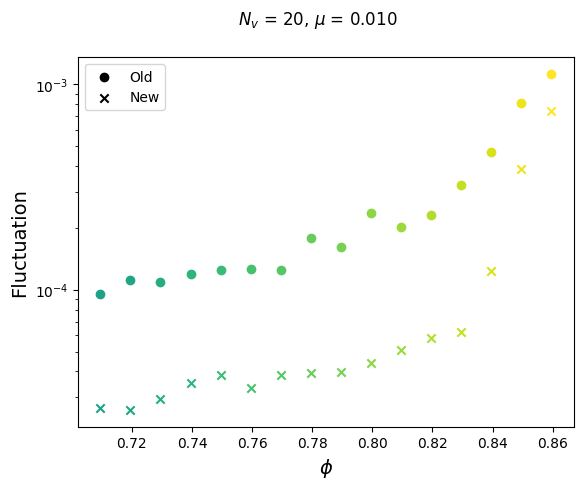

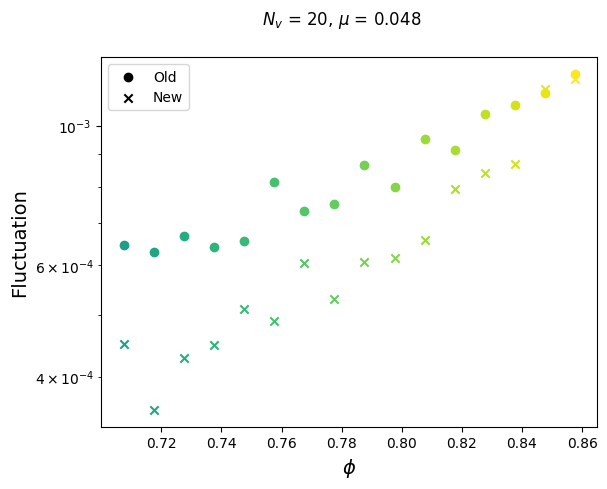

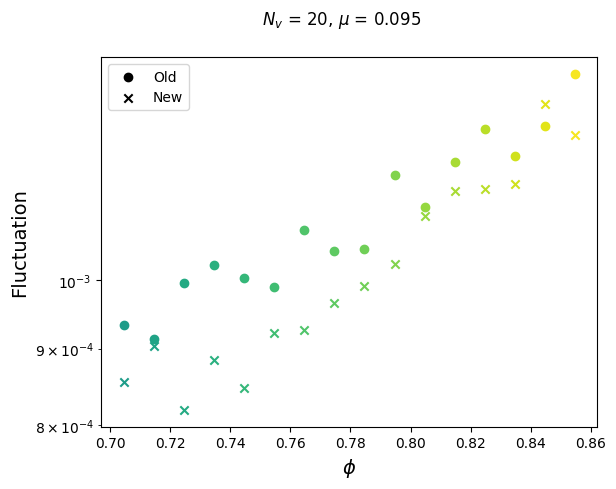

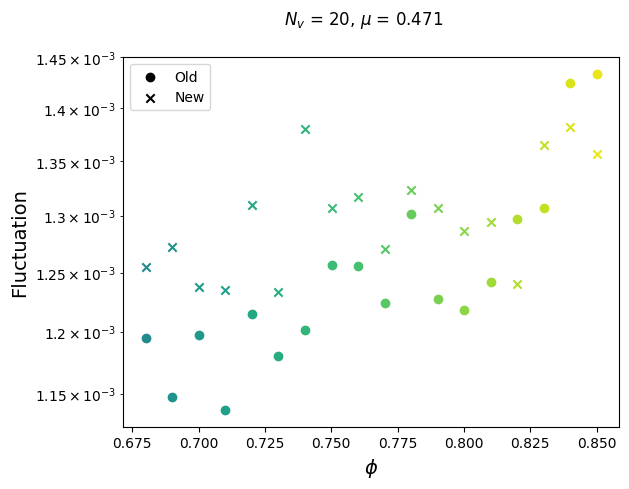

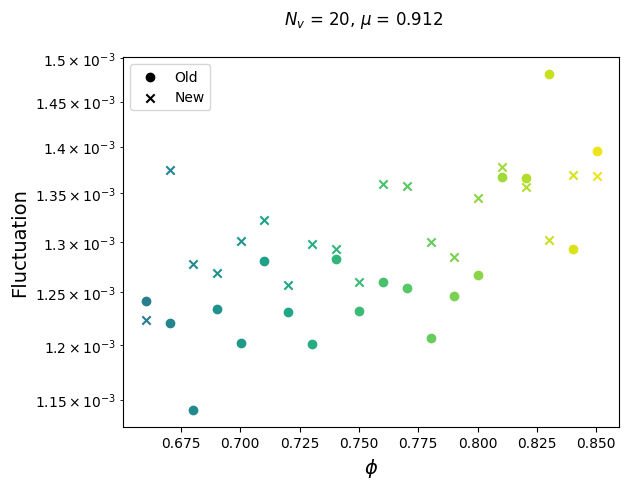

In [6]:
nv = 21
for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
    for d in dataset:
        if d['n_vertices'] != nv:
            continue
        if d['mu_eff'] != mu:
            continue
        plt.scatter(d['phi'], d['ke_rot_fluc'], c=cmap(phi_norm(d['phi'])), marker='o' if d['is_old'] else 'x')
    plt.scatter([], [], c='k', marker='o', label=r'Old')
    plt.scatter([], [], c='k', marker='x', label=r'New')
    plt.ylabel('Fluctuation', fontsize=14)
    plt.xlabel(r'$\phi$', fontsize=14)
    plt.legend()
    plt.yscale('log')
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}, $\mu$ = {mu:.3f}')
    plt.show()

/tmp/ipykernel_1925270/527634233.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
/tmp/ipykernel_1925270/527634233.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
/tmp/ipykernel_1925270/527634233.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA

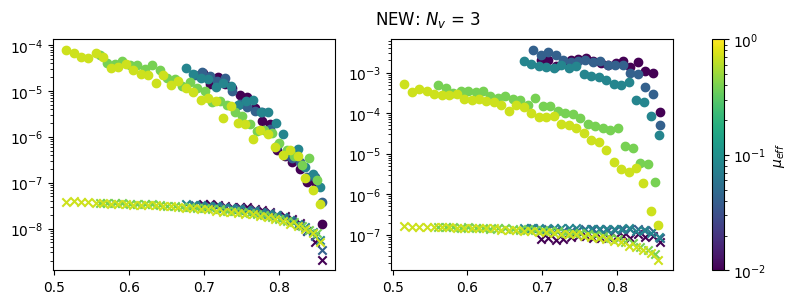

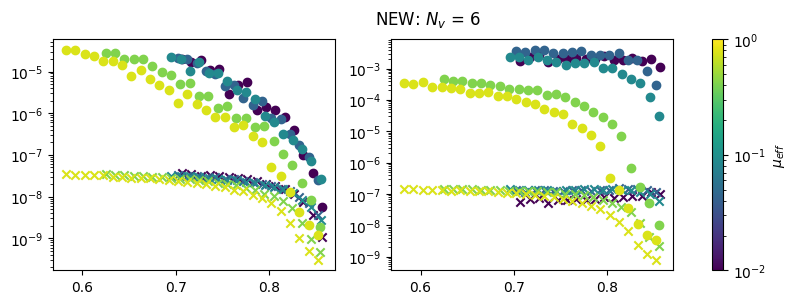

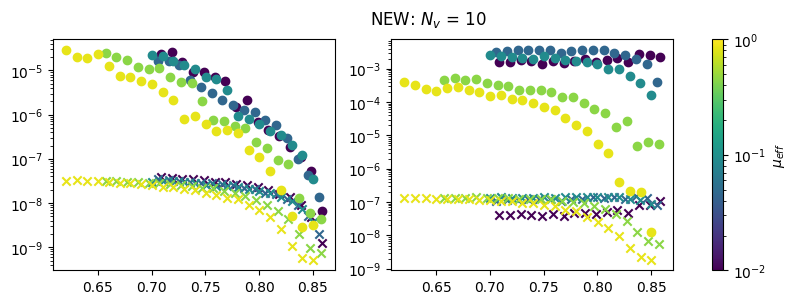

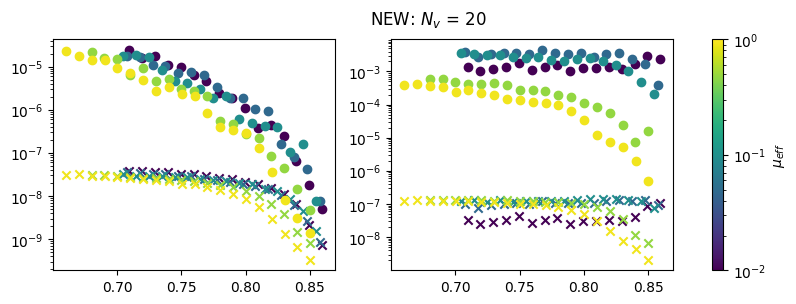

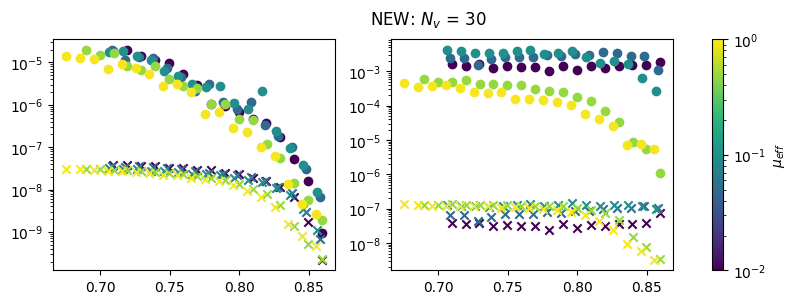

In [42]:
mu_norm = LogNorm(vmin=1e-2, vmax=1)
for nv in np.unique([d['n_vertices'] for d in dataset]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
        for d in dataset:
            if d['n_vertices'] != nv:
                continue
            if d['mu_eff'] != mu:
                continue
            if d['is_old']:
                continue
            ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
            ax[1].scatter(d['phi'], d['D_R_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[1].scatter(d['phi'], d['D_R_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
        for a in ax:
            a.set_yscale('log')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]))
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.suptitle(fr'NEW: $N_v$ = {int(nv) - 1}')
    plt.show()

/tmp/ipykernel_1925270/2302821633.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
/tmp/ipykernel_1925270/2302821633.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
/tmp/ipykernel_1925270/2302821633.py:14: UserWarning: *c* argument looks like a single numeric RGB or R

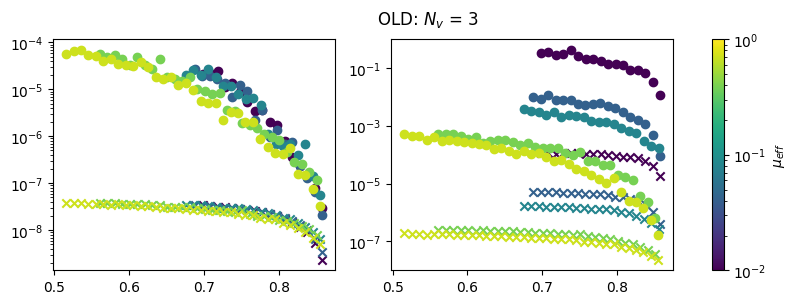

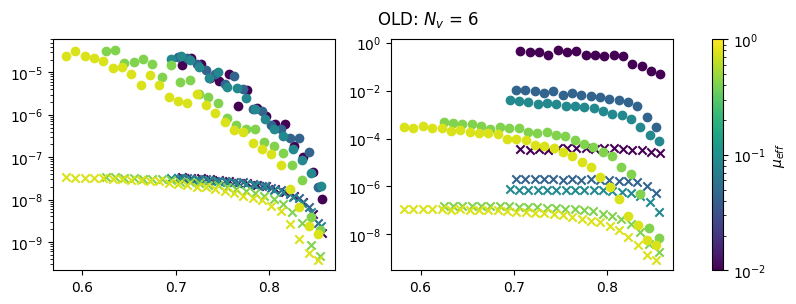

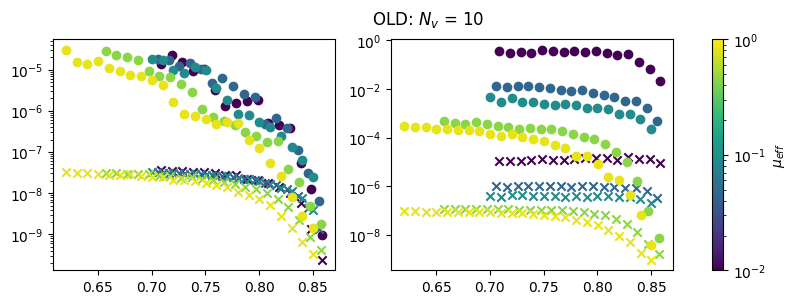

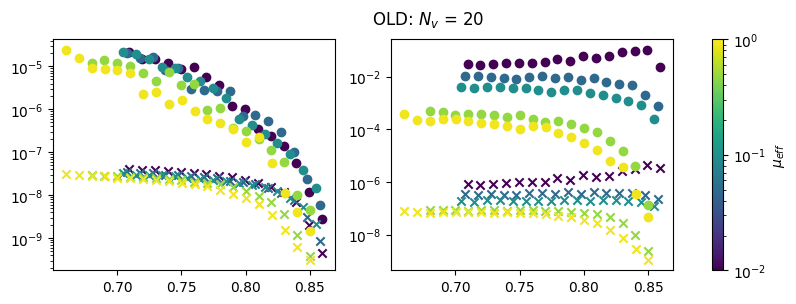

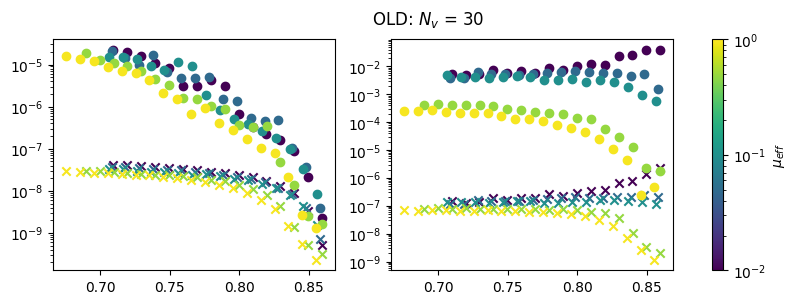

In [41]:
mu_norm = LogNorm(vmin=1e-2, vmax=1)
for nv in np.unique([d['n_vertices'] for d in dataset]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for mu in np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]):
        for d in dataset:
            if d['n_vertices'] != nv:
                continue
            if d['mu_eff'] != mu:
                continue
            if not d['is_old']:
                continue
            ax[0].scatter(d['phi'], d['D_T_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[0].scatter(d['phi'], d['D_T_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
            ax[1].scatter(d['phi'], d['D_R_long'], c=cmap(mu_norm(d['mu_eff'])))
            ax[1].scatter(d['phi'], d['D_R_short'], c=cmap(mu_norm(d['mu_eff'])), marker='x')
        for a in ax:
            a.set_yscale('log')
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(np.unique([d['mu_eff'] for d in dataset if d['n_vertices'] == nv]))
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.suptitle(fr'OLD: $N_v$ = {int(nv) - 1}')
    plt.show()